Cell 1 loads up all the libraries we are using. In the first lessons, we used fastAI, while in this one we use Tensorflow with Keras. Both of these are large libraries, and its designers decided to allow programmers to load only the pieces that are relevant, which is what the 'from keras.XXX import YYY' lines do--they load just the partrt of Keras (or other library) that we want. This makes the load time faster and the final running program smaller.

The second half of this cell does the familiar step of loading the data sets that I have prepared, which in this case are a series of abdominal CTs as well as hand-traced masks of the Pancreas, courtesy of The Cancer Image Archive: http://TheCancerImageArchive....

In [3]:
#Cell 1
%tensorflow_version 1.x 
!pip install -q keras
!pip install natsort
import numpy as np
import numpy.ma as ma
import os
import shutil
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.engine.topology import Layer

from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from natsort import natsorted
import random
import warnings
warnings.filterwarnings("ignore")


!rm -rf trainimages
!mkdir trainimages
!rm -rf trainmasks
!mkdir trainmasks

!rm -rf validationimages
!mkdir validationimages
!rm -rf validationmasks
!mkdir validationmasks

!rm -rf testimages
!mkdir testimages
!rm -rf testmasks
!mkdir testmasks


!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12ZMgXhe5xSQvLNncQmw6YUqA5gHmUCsp' -O ./Pt1.zip
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V4zAE19E1kLUK0Z0YIWNpMq0K8lOARtu' -O ./Pt2.zip

!unzip -q -o "./Pt1.zip"

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1byMzywRyMtRqildQrFyR1w44eyKyaHcb' -O ./Pt3.zip
!unzip -q -o "./Pt3.zip"

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CN5QXK1HLdZY4Or0FFyIAUYPm9yLWU9W' -O ./Pt4.zip
!unzip -q -o "./Pt4.zip"


--2020-09-02 18:30:54--  https://docs.google.com/uc?export=download&id=12ZMgXhe5xSQvLNncQmw6YUqA5gHmUCsp
Resolving docs.google.com (docs.google.com)... 173.194.69.113, 173.194.69.100, 173.194.69.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h2skn2fdc4sq68p2o64vtnuh80uoaq71/1599071400000/16160187475894979440/*/12ZMgXhe5xSQvLNncQmw6YUqA5gHmUCsp?e=download [following]
--2020-09-02 18:30:58--  https://doc-04-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h2skn2fdc4sq68p2o64vtnuh80uoaq71/1599071400000/16160187475894979440/*/12ZMgXhe5xSQvLNncQmw6YUqA5gHmUCsp?e=download
Resolving doc-04-60-docs.googleusercontent.com (doc-04-60-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-04-60-docs.googleusercontent.com (doc-04-60-

#Data Wrangling
Here we organize the data into training, validation and testing sets, with each having an image and mask, so 6 directories total. I started with the TCIA-Pancreas data set, which has hand-traced contours of the pancreas.
I took each image that had some pancreas traced, applied 400/40 W/L settings, converted to 8 bits, and then cropped to the central 256x256 (just to reduce memory demands). The mask is also cropped to match, and is either o or 1.
THese are then loaded into the respective memory arrays.

In [4]:
# Cell 2

train_X = []
train_Y = []
val_X = []
val_Y = []
test_X = []
test_Y = []

im_list = natsorted(os.listdir('./trainimages'))
for f in im_list:
  pth = './trainimages/' + f 
  img = imageio.imread(pth)
  train_X.append(np.array(img))
train_X = np.array(train_X)
train_X = train_X/255
train_X = train_X[..., np.newaxis]

im_list = natsorted(os.listdir('./trainmasks'))
for f in im_list:
  pth = './trainmasks/' + f 
  img = imageio.imread(pth)
  train_Y.append(np.array(img))
train_Y = np.array(train_Y)
train_Y = (train_Y > 0).astype(np.float32)
train_Y = train_Y[..., np.newaxis]

im_list = natsorted(os.listdir('./validationimages'))
for f in im_list:
  pth = './validationimages/' + f 
  img = imageio.imread(pth)
  val_X.append(np.array(img))
val_X = np.array(val_X)
val_X = val_X/255
val_X = val_X[..., np.newaxis]

im_list = natsorted(os.listdir('./validationmasks'))
for f in im_list:
  pth = './validationmasks/' + f 
  img = imageio.imread(pth)
  val_Y.append(np.array(img))
val_Y = np.array(val_Y)
val_Y = (val_Y > 0).astype(np.float32)
val_Y = val_Y[..., np.newaxis]

im_list = natsorted(os.listdir('./testimages'))
for f in im_list:
  pth = './testimages/' + f 
  img = imageio.imread(pth)
  test_X.append(np.array(img))
test_X = np.array(test_X)
test_X = test_X/255
test_X = test_X[..., np.newaxis]

im_list = natsorted(os.listdir('./testmasks'))
for f in im_list:
  pth = './testmasks/' + f 
  img = imageio.imread(pth)
  test_Y.append(np.array(img))
test_Y = np.array(test_Y)
test_Y = (test_Y > 0).astype(np.float32)
test_Y = test_Y[..., np.newaxis]

print(train_X.shape[0],"images for training,", val_X.shape[0], "images for validation, and", test_X.shape[0], "images for testing")

WIDTH = train_X.shape[2]
HEIGHT = train_X.shape[1]
CHANNELS = 1
#print ('X and Y dims are ' + str(WIDTH) + 'x' + str(HEIGHT))

837 images for training, 117 images for validation, and 49 images for testing


#Cost Functions
A critical element of every machine learning algorithm is to select a good cost function. In the classificaiton problems of prior articles, we used the accuracy of predictions as the cost function. For segmentation, one potentially could compute a score for teh classification of each pixel (object or not object), but a more common metric is the Dice Similiarity Score (a.k.a. Dice Score). This essentially means the amount of overlap between the gold standard and the prediction. If they perfectly agree, the Dice Score is 1, and if there is no overlap, the score is 0. We can convert the Dice Score toa Dice Loss by subtracting it from 1. One can also convert the Dice Score to a cross-entropy function, and this can work well in some cases. Code for both is provided, and you are encouraged to try both cost functions to see the effect. Note, however, that the above can result in Dice values of zero, and we don't want to divide by zero. In fact, we don't want to divide by a small number, so we add 'smooth' to the value (in our case we are using 1) so the values of Dice actually are 1 to 2, not 0 to 1. And that means the Dice Loss will be -1 to 0, but the loss reported is the sum, so it will have a larger range.


In [5]:
# Cell 3
def dice_coeff(y_true, y_pred):
    # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
    # we only care about relative value, not absolute so this alteration doesn't matter
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
get_custom_objects().update({"dice": dice_loss})

class LayerNormalization (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        x /= K.std (x, axis = axis, keepdims = True) + K.epsilon()
        x -= K.mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

#Building the U-Net
We are finally ready to build our Network. One difference of Keras versus the previous examples of FastAI is that Keras is designed so that there is one line of code for each layer of the network (plus the setup and training/evlauation code). This means that for a moderately complex network like a ResNet34 classifier, there would be 34 lines of code. U-Nets are popular network architectures for segmentation. These get their name because of the unique way they are built: The first part produces repeated reductions in resolution as the 'important' parts of the image are retained that reflect the structures that it is trained to recognize. Typically there are 4 or 5 such reduction layers that each consist of convultions, ReLUs, and Pooling layers. Once the image is reduced to the critical components, the networks begins to reconstruct the precise margins of the critical elements by using 'skip layers'. As the resolution is stored using convolutional-transpose layers, the layers 'look' back to the layers where the resolution was reduced to try to best define the margins of the structures. See Ronneberger (Ronneberger, Olaf; Fischer, Philipp; Brox, Thomas (2015). "U-Net: Convolutional Networks for Biomedical Image Segmentation". arXiv:1505.04597  https://arxiv.org/pdf/1505.04597.pdf).

There is a lot more going on that I will only provide references to (these will be covered in the future):
1. ReLU Activation Function: https://arxiv.org/pdf/1502.01852.pdf
2. Kernel Intialization (the weights loaded into the network before anything is done): https://arxiv.org/pdf/1502.01852.pdf
3. Transpose Convolution: https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8#Building the U-Net


In [6]:
# Cell 4
def build_model(act_fn = 'relu', init_fn = 'he_normal', width=256, height = 256, channels = 1): 
    inputs = Input((width,height,channels))

    # note we use linear function before layer normalization
    conv1 = Conv2D(8, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(72, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)

    up6 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)

    up7 = Conv2D(32, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)

    up8 = Conv2D(16, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)

    up9 = Conv2D(8, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'dice', metrics=[dice_coeff])
    return model



#Train it
Now that our model is built, we are (finally!) ready to train it. Trial and error with colab hardware (K80) has shown that a batch_size of 16 works, and that we can get reasonable results adfter 5 epochs (but you can train longer to get better results)

In [13]:
# Cell 5
model = build_model(act_fn = 'relu', init_fn = 'he_normal', width=WIDTH, height = HEIGHT, channels = CHANNELS)

checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

###########  I get 2.5 seconds per epoch on colab pro. so 70 epochs is almost 3 minutes
###########  It will take a couple of hours to get pretty good results, but 300 gets reasonable enough considering difficulty of pancreas
epochs = 70
batch_size = 128
results = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 837 samples, validate on 117 samples
Epoch 1/70
837/837 [==============================] - 3s 4ms/step - loss: 0.9638 - dice_coeff: 0.0361 - val_loss: 0.9568 - val_dice_coeff: 0.0432

Epoch 00001: val_loss improved from inf to 0.95682, saving model to model.h5
Epoch 2/70
837/837 [==============================] - 2s 2ms/step - loss: 0.9565 - dice_coeff: 0.0439 - val_loss: 0.9529 - val_dice_coeff: 0.0471

Epoch 00002: val_loss improved from 0.95682 to 0.95294, saving model to model.h5
Epoch 3/70
837/837 [==============================] - 2s 2ms/step - loss: 0.9509 - dice_coeff: 0.0495 - val_loss: 0.9456 - val_dice_coeff: 0.0544

Epoch 00003: val_loss improved from 0.95294 to 0.94558, saving model to model.h5
Epoch 4/70
837/837 [==============================] - 2s 2ms/step - loss: 0.9396 - dice_coeff: 0.0610 - val_loss: 0.9317 - val_dice_coeff: 0.0683

Epoch 00004: val_loss improved from 0.94558 to 0.93168, saving model to model.h5
Epoch 5/70
837/837 [==========================

#Test it!
Now that the model is trained, we can test our segmentation tool on the test holdout cases. Note that the prediction is the probability that a pixel is object (pancreas) or not object (anything other than pancreas). We use 0.5 as the threshold for deciding Pancreas or not, though again you can adjust this if your task might view it as more valuable to include non-pancreas pixels in order to reduce the number of missed pancreas pixels.
Note also that we calculate the Dice Score. The Dice calculated in training is not the actual Dice score, but it is proportional (we make adjustments so it is never 0 or have a divide by 0 error), and therefore works.

49/49 [==============================] - 1s 14ms/step


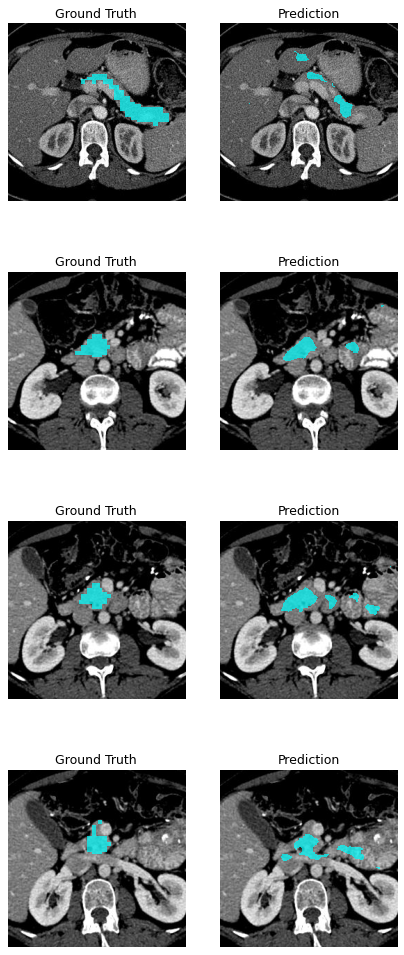

The dice score for this model is:  0.4488753291042485


In [14]:
# Cell 6
model.load_weights("./model.h5")
preds_test = model.predict(test_X, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)

def np_dice(true, pred):
    intersection = np.sum(true * pred)
    dc =(2.0 * intersection) / (np.sum(true) + np.sum(pred))
    return dc

fig=plt.figure(figsize=(130, 130), dpi = 75)

for j in range(0,8,2):
    i = random.randint(0,test_X.shape[0]-1)
    image = test_X[i,...,0]
    mask =  test_Y[i,...,0]
    mask = ma.masked_where(mask == 0, mask)
    pred = preds_test[i,...,0]
    pred = ma.masked_where(pred == 0, pred)
    
    fig.add_subplot(8, 2, j+1)
    plt.imshow(image, cmap = "gray")
    plt.imshow(mask, 'cool', alpha=0.7)
    plt.title("Ground Truth")
    plt.axis('off')
    
    fig.add_subplot(8, 2, j+2)
    plt.imshow(image, cmap = "gray")
    plt.imshow(pred, 'cool', alpha=0.7)
    plt.title("Prediction")
    plt.axis('off')
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()

print("The dice score for this model is: ", np_dice(test_Y, preds_test))